### Imports

In [18]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import matplotlib.pyplot as plt
import numpy as np
import subjects
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from plotters import Plotter, get_nsd_vs_sd_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

grpdata = subjects.GroupData()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from scipy.ndimage import gaussian_filter1d
from neuropy import plotting
from scipy import stats
import subjects
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Raster plots

In [ ]:
sess = subjects.nsd.ratRday1[0]
neurons = sess.neurons_stable.get_neuron_type("pyr")

_, ax = plt.subplots()
plotting.plot_raster(neurons, ax=ax)

### Firing rate change at NREM-REM transition during recovery sleep vs regular sleep
There can be two ways to look at the changes in firing rate
- mua firing rate (but it does not make sense, as high firing rate neurons can blur the changes)
- normalize/zscore each neurons firing rate during transition and then calculate the mean across neurons 
    - firing rate increase towards the end of NREM and decrese during following REM. This is consistent with Miyawaki and Diba (2016)

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]

In [ ]:
df = pd.DataFrame()
binsz = 2
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values

        for i in range(len(labels) - 1):
            if (labels[i] == "nrem") and (labels[i + 1] == "rem"):
                # ---- MUA -----
                # nrem_mua = pyr.get_mua(t_start=states.iloc[i].start,t_stop=states.iloc[i].stop,bin_size=4)
                # rem_mua = pyr.get_mua(t_start=states.iloc[i+1].start,t_stop=states.iloc[i+1].stop,bin_size=4)
                # frate = np.hstack((nrem_mua.spike_counts,rem_mua.spike_counts))
                # bins = np.arange(-nrem_mua.n_bins,rem_mua.n_bins)

                # --- zscored firing rate ---------
                nrem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i].start,
                    t_stop=states.iloc[i].stop,
                    bin_size=binsz,
                )
                rem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i + 1].start,
                    t_stop=states.iloc[i + 1].stop,
                    bin_size=binsz,
                )
                bins = np.arange(-nrem_binspk.n_bins, rem_binspk.n_bins)
                frate = np.nanmean(
                    stats.zscore(
                        np.hstack((nrem_binspk.spike_counts, rem_binspk.spike_counts)),
                        axis=1,
                    ),
                    axis=0,
                )

                df = df.append(pd.DataFrame({"bins": bins, "frate": frate, "grp": grp}))

In [ ]:
figure = Fig()
fig, gs = figure.draw(grid=(1, 1), size=(5, 4), style="Pres")
ax = plt.subplot(gs[0])
df_ = df.groupby("grp")
color = ["r", "k"]
for i, grp in enumerate(["sd", "nsd"]):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby("bins").mean().frate
    sem_frate = grp_df.groupby("bins").sem(ddof=0).frate
    ax.fill_between(
        mean_frate.index.values,
        mean_frate - sem_frate,
        mean_frate + sem_frate,
        color=color[i],
        alpha=0.3,
        ec=None,
    )
    ax.plot(mean_frate.index.values, mean_frate, color=color[i], alpha=0.6)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')

ax.legend(["sd rec. slp.", "nsd"])
ax.axvline(x=0, ls="--")
ax.set_xlim([-50, 30])
ax.set_ylim([-0.4, 0.4])
ax.set_title("NREM-REM transition")
ax.set_ylabel("Normalized firing rate")
ax.set_xlabel("Time bin from start of REM")
figure.savefig(
    "nrem-rem_transition_frate_sd_vs_nsd", folder="/home/bapung/Documents/figures"
)

### Firing rate changes within NREM during and SD and compare with NSD
- Firing rate first decreases and then increases ? Not consistent with Miyawaki and Diba 2016 ?

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd, sessions_nsd)

In [ ]:
df = pd.DataFrame()
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values
        nrems = states[(states["label"] == "nrem") & (states["duration"] > 240)]

        for nrem in nrems.itertuples():
            bins, binsz = np.linspace(nrem.start, nrem.stop, 10, retstep=True)

            nrem_binspk = pyr.get_binned_spiketrains(
                t_start=nrem.start, t_stop=nrem.stop, bin_size=binsz
            )

            frate = np.nanmean(stats.zscore(nrem_binspk.spike_counts, axis=1), axis=0)

            df = df.append(
                pd.DataFrame(
                    {
                        "bins": np.linspace(0, 1, nrem_binspk.n_bins),
                        "frate": frate,
                        "grp": grp,
                    }
                )
            )

In [ ]:
figure = Fig()
fig, gs = figure.draw(grid=(1, 1), size=(5, 4), style="Pres")
ax = plt.subplot(gs[0])
df_ = df.groupby("grp")
color = ["#26507e", "#79a7d7"]
z = 1
for i, grp in enumerate(["sd", "nsd"]):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby("bins").mean().frate
    sem_frate = grp_df.groupby("bins").sem(ddof=0).frate
    ax.fill_between(
        mean_frate.index.values,
        mean_frate - sem_frate,
        mean_frate + sem_frate,
        color=color[i],
        alpha=0.3,
        ec=None,
        zorder=z,
    )
    ax.plot(mean_frate.index.values, mean_frate, color=color[i], zorder=z + 1)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')
    z += 2

ax.legend(["sd rec. slp.", "nsd"])
ax.set_title("Firing rate changes within NREM")
ax.set_ylabel("Normalized firing rate")
ax.set_xlabel("Time bin from start of NREM")
figure.savefig(subjects.fig_folder / "nrem-rem_transition_frate_sd_vs_nsd")

### Firing rate changes across sleep deprivation individual neurons or quantiles
- something simiilar to firing rate homeostasis

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess[1:-1]
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd, sessions_nsd)

In [ ]:
bin_size = 60
for sub, sess in enumerate(sessions_sd[2:3]):
    post = sess.paradigm["post"]
    sd = [post[0], post[0] + 5 * 3600]
    neurons = sess.neurons.get_neuron_type("pyr").time_slice(t_start=sd[0], t_stop=sd[1])
    binspk = neurons.get_binned_spiketrains(bin_size=bin_size)
    zsc_binspk = stats.zscore(binspk.spike_counts / bin_size, axis=1)

In [ ]:
%matplotlib widget
plt.plot(zsc_binspk[5:10,:].T)
# plt.yscale('log')

### Participation rate within ripples as function of sleep deprivation

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sd_sessions = subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions, nsd_sessions)

In [ ]:
for grp_ind, grp in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(grp):
        rpl = sess.ripple

### Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated after pooling all the cells into a big group

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sd_sessions = subjects.sd.allsess[1:-1]
nsd_sessions = subjects.nsd.ratNday2 + subjects.nsd.ratSday2 + subjects.nsd.ratUday2
print(sd_sessions)
print(nsd_sessions)

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
for neuron_type in ["pyr"]:
    for sessions, grp in zip([sd_sessions, nsd_sessions], ["sd", "nsd"]):
        pre_to_maze = []
        post_frate = []
        for sub, sess in enumerate(sessions):
            pre = sess.paradigm["pre"]
            maze = sess.paradigm["maze"]
            if maze.size == 0:
                maze = sess.paradigm["maze1"]
            post = sess.paradigm["post"]
            rec_duration = sess.eegfile.duration
            neurons = sess.neurons.get_neuron_type(neuron_type)
            neurons_stable_bool = neurons_stability.firing_rate_stability(
                neurons=neurons, window=4 * 3600
            )
            neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

            f_rate = []
            for i, (t_start, t_end) in enumerate(
                zip([pre[0], maze[0]], [pre[1], maze[1]])
            ):
                f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

            f_rate = np.asarray(f_rate).T
            pre_to_maze.append(np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0])

            binspk = neurons.time_slice(
                post[0], post[0] + 5 * 3600
            ).get_binned_spiketrains(bin_size=bin_size)

            post_frate.append(binspk.spike_counts / bin_size)

        pre_to_maze = np.concatenate(pre_to_maze)
        post_frate = np.vstack(post_frate)

        quantiles = pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
        quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
        quant_mean_frate = np.asarray(quant_mean_frate)
        first_bin = quant_mean_frate[:, 0]
        quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

        df = pd.DataFrame(quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1]))
        df["grp"] = grp
        df["quantiles"] = np.arange(nQuantiles)
        frate_maze_vs_sd = frate_maze_vs_sd.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(20),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw()

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
    )
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.4,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    if i==0:
        figure.panel_label(ax_1v5,'E')



### Cells increasing their firing rate the most from pre to maze and dividing them into quantiles
- quantiles were estimated individually for each session

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 3
bin_size = 15 * 60

frate_quantiles = []
frate_quantiles_shuffles = []

for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    if maze.size == 0:
        maze = sess.paradigm["maze1"].flatten()
    post = sess.paradigm["post"].flatten()
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons_stable.get_neuron_type("pyr")

    if neurons.n_neurons > 1:
        frate_pre = neurons.time_slice(pre[0], pre[1]).firing_rate
        frate_maze = neurons.time_slice(maze[0], maze[1]).firing_rate
        frate_change_pre_to_maze = (frate_maze - frate_pre) / frate_pre

        binspk = neurons.time_slice(post[0], post[0] + 8 * 3600).get_binned_spiketrains(
            bin_size=bin_size
        )

        sess_post_frate = binspk.spike_counts / bin_size
        # sess_post_frate /= sess_post_frate[:,0,np.newaxis]
        # sess_post_frate = sess_post_frate

        # --- quantile categorization ---
        # sub_ind.append(sub * np.ones(neurons.n_neurons))

        df = pd.DataFrame(data=sess_post_frate, columns=np.arange(binspk.n_bins))
        df["quant"] = pd.qcut(frate_change_pre_to_maze, q=nQuantiles, labels=False)
        df["animal"] = sub
        df["grp"] = sess.tag
        frate_quantiles.append(df)

frate_quantiles = pd.concat(frate_quantiles, ignore_index=True)


# #---- shuffles --------------
# frate_quantiles_shuffles=[]
# for i in range(1000):
#     quantiles_shuffle = quantiles.copy()
#     np.random.shuffle(quantiles_shuffle)
#     quant_mean_frate = [
#         np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0)
#         for q in range(nQuantiles)
#     ]

#     quant_mean_frate = np.asarray(quant_mean_frate)
#     first_bin = quant_mean_frate[:, 0]
#     quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

#     df = pd.DataFrame(
#         quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
#     )
#     df["grp"] = grp
#     df["quantiles"] = np.arange(nQuantiles)
#     frate_quantiles_shuffles.append(df)
# frate_quantiles_shuffles = pd.concat(frate_quantiles_shuffles,ignore_index=True)

frate_quantiles = pd.melt(
    frate_quantiles,
    id_vars=["grp", "quant", "animal"],
    value_vars=np.arange(binspk.n_bins),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_quantiles["bins"] = frate_quantiles["bins"] * (bin_size / 3600)

# frate_maze_vs_sd_shuffled = pd.melt(
#     frate_maze_vs_sd_shuffled,
#     id_vars=["grp", "quantiles"],
#     value_vars=np.arange(quant_mean_frate.shape[1]),
#     var_name=["bins"],
#     value_name="frate",
#     ignore_index=True,
# )

# frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (
#     bin_size / 3600
# )

subjects.GroupData().save(frate_quantiles, "frate_pre_to_maze_quantiles_in_POST")
# subjects.GroupData().save(
#     frate_maze_vs_sd_shuffled, "frate_pre_to_maze_quantiles_in_POST_shuffled"
# )

#### Plotting mean across all sessions

In [ ]:
df = frate_quantiles.groupby(["grp", "quant", "bins"]).mean().reset_index()
sns.catplot(
    data=frate_quantiles,
    x="quant",
    y="frate",
    hue="bins",
    # row='quant',
    col="grp",
    kind="box",
    palette="Reds",
    # join=False,
    # s=2,
    dodge=True,
    showfliers=False,
)

#### Plotting each animal individually

In [ ]:
from matplotlib.cm import get_cmap

fig = plotting.Fig(grid=(8, 2), constrained_layout=False)
for i, grp in enumerate(["NSD", "SD"]):
    df = frate_quantiles[frate_quantiles["grp"] == grp]
    animals = df["animal"].unique()

    for i1 in range(len(animals)):
        ax = fig.subplot(fig.gs[i1, i])
        df_animal = df[df["animal"] == animals[i1]]
        for q in range(5):
            frate = df_animal[df_animal["quant"] == q].groupby("bins").mean().frate.values
            # frate /= frate[0]

            # sns.lineplot(
            #     data=df_animal,
            #     x="bins",
            #     y="frate",
            #     hue="quant",
            #     ci=None,
            #     ax=ax,
            # )
            t = np.arange(len(frate)) * (15 / 60)
            cmap = get_cmap("Reds")
            ax.plot(t, frate, color=cmap(q / 6 + 0.2))
        ax.axhline(1, color="k", ls="--")
        ax.legend("", frameon=False)
        ax.set_yscale("log")

fig.savefig(subjects.figpath_sd / "quantiles_firing_rate_NSDvsSD_raw")

#### Plotting with shuffles

In [ ]:
# from palettable.colorbrewer.sequential import Oranges_6, Purples_6
# from neuropy.plotting import Fig
# fig = Fig(grid=(3,2))

# colors = subjects.colors_sd(1)
# palette = [Oranges_6, Purples_6]
# for i, grp in enumerate(["sd", "nsd"]):
#     ax_1v5 = plt.subplot(fig.gs[i])
#     df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp)]
#     df_shuffled = frate_quantiles[(frate_quantiles["grp"] == grp)]
#     sns.lineplot(
#         data=df_shuffled,
#         x="bins",
#         y="frate",
#         hue="quantiles",
#         palette=['#ababab']*5,
#         legend=None,
#         ax=ax_1v5,
#         alpha = 0.5,
#         estimator = np.nanmean,
#     )
#     sns.lineplot(
#         data=df,
#         x="bins",
#         y="frate",
#         hue="quantiles",
#         palette=palette[i].hex_colors[1:],
#         legend=None,
#         ax=ax_1v5
#     )
#     # ax_1v5.set_yscale('log')
#     ax_1v5.axhline(1,ls='--',color='gray')
#     ax_1v5.set_ylim(bottom=0.4,top=1.9)
#     ax_1v5.set_ylabel('Firing rate ratio')
#     ax_1v5.set_xlabel('Zt time (h)')
#     if i==0:
#         figure.panel_label(ax_1v5,'E')

# # ax_caption = plt.subplot(gs[1, :])
# # ax_caption.text(
# #     0,
# #     0,
# #     "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
# #     wrap=True,
# # )
# # ax_caption.axis("off")

# # figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_ZT5')

### Change in firing rate from 1st to 5th hour of POST (SD vs NSD)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

sessions = subjects.sd.pf_sess + subjects.nsd.pf_sess

In [ ]:
from neuropy.analyses import neurons_stability

frate_1v5_df = pd.DataFrame()
for neuron_type in ["pyr", "inter"]:
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"].flatten()
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons.get_neuron_type(neuron_type)
        neurons_stable_bool = neurons_stability.firing_rate_stability(
            neurons=neurons.time_slice(post[0], post[0] + 5 * 3600)
        )
        neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

        f_rate = []
        for i, (t_start, hour) in enumerate(
            zip([post[0], post[0] + 4 * 3600], ["0-1", "4-5"])
        ):
            f_rate.append(neurons.time_slice(t_start, t_start + 3600).firing_rate)

        f_rate = np.asarray(f_rate).T

        frate_1v5_df = frate_1v5_df.append(
            pd.DataFrame(
                {
                    # "hour": hour,
                    "frate": (np.diff(f_rate, axis=1) * 100)[:, 0] / f_rate[:, 0],
                    "sub": sub,
                    "grp": sess.tag,
                    "neuron_type": neuron_type,
                }
            ),
            ignore_index=True,
        )

subjects.GroupData().save(frate_1v5_df, "frate_change_1vs5")

### firing rate in 2.5 hour windows(SD vs NSD)
- Initially this compute frate ratio relative to PRE but later we decided to have raw firing rates

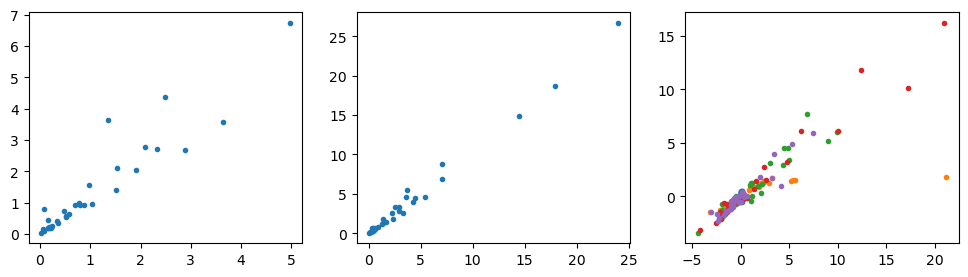

In [44]:
# Sanity check - why does PRE + POST normalization give such weird results? They don't make sense given FR distribution.
_, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(pre_frate_std, pre_maze_frate_std, '.')
ax[1].plot(pre_frate_mean, pre_maze_frate_mean, '.')
ax[2].plot(frate_zscore_pre, frate_zscore_pre_maze, '.')

In [5]:
sessions = subjects.mua_sess()[1:]
sessions[13]

ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml)

In [17]:
sessions[13].get_zt_epochs().to_dataframe().loc[0, ["start", "stop"]].values

array([410.0, 9410.0], dtype=object)

In [24]:
pre_states_df = sessions[13].brainstates.time_slice(*sessions[13].get_zt_epochs().to_dataframe().loc[0, ["start", "stop"]].values)
pre_states_df.time_slice(6639, 6883)

0 epochs
Snippet: 
 Empty DataFrame
Columns: [start, stop, label]
Index: []

In [22]:
sessions[13].artifact

77 epochs
Snippet: 
         start        stop label
0   6639.6712   6883.2528      
1  11035.8096  11035.8944      
2  11047.2128  11048.6176      
3  13449.7896  13449.9208      
4  14061.5072  14061.6480      

In [15]:
sessions = subjects.mua_sess()[1:]

In [16]:
sessions

[ProcessData(RatK_Day2_2019-08-08_04-00-00.xml),
 ProcessData(RatN_Day2_2019-10-11_03-58-54.xml),
 ProcessData(RatS-Day2NSD-2020-11-27_10-22-29.xml),
 ProcessData(RatR_Day1NSD_2021-05-13_08-41-31.xml),
 ProcessData(RatU_Day2NSD_2021-07-24_08-16-38.xml),
 ProcessData(RatV_Day1NSD_2021-10-02_08-10-23.xml),
 ProcessData(RatV_Day3NSD_2021-10-07_08-10-12.xml),
 ProcessData(RatJ_Day1_2019-05-31_03-55-36.xml),
 ProcessData(RatK_Day1_2019-08-06_03-44-01.xml),
 ProcessData(RatN_Day1_2019-10-09_03-52-32.xml),
 ProcessData(RatS_Day3SD_2020-11-29_07-53-30.xml),
 ProcessData(RatR_Day2SD_2021-05-23_09-07-18.xml),
 ProcessData(RatU_Day1SD_2021-07-22_07-55-46.xml),
 ProcessData(RatU_Day4SD_2021-07-29_08-23-06.xml),
 ProcessData(RatV_Day2SD_2021-10-04_08-02-10.xml)]

In [14]:
neurons = sessions[0].neurons_stable.get_neuron_type(["pyr", "inter"])

In [17]:
sessions[0].name

'RatKDay2'

In [11]:
neurons = sessions[8].neurons_stable.get_neuron_type(["pyr", "inter"])
neurons.to_dataframe()

Number of neurons: 13


,neuron_type,nspikes,mean_frate
0,inter,782844,13.956266
1,pyr,198344,3.536007
2,pyr,210869,3.759298
3,pyr,30677,0.546899
4,pyr,36682,0.653954
5,pyr,102804,1.832753
6,pyr,5329,0.095004
7,pyr,81649,1.455610
8,pyr,11597,0.206747
9,pyr,5672,0.101118


In [22]:
sessions = subjects.mua_sess()[1:]  ### Exclude RatJDay2 included

from neuropy.analyses import neurons_stability

zt_labels = ["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]
frate_df, frate_change_df, frate_zscore_pre_df = [], [], []
frate_zscore_maze_df, frate_zscore_pre_maze_df, frate_log_df = [], [], []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])  # loads .neurons.stable.npy ...

    print(len(neurons))  # Cheap progress bar
    epochs = sess.get_zt_epochs()

    frate_epochs = []
    for i, (t1, t2) in enumerate(epochs.as_array()):
        n_spikes = neurons.time_slice(t1, t2).n_spikes
        artifact_dur = (
            0
            if artifact is None
            else artifact.time_slice(t1, t2, strict=False).durations.sum()
        )
        duration = t2 - t1 - artifact_dur
        frate_epochs.append(n_spikes / duration)
    frate_epochs = np.asarray(frate_epochs).T

    # ----- change relative to baseline -------
    baseline = frate_epochs[:, 0, np.newaxis]
    frate_change = frate_epochs[:, :] / baseline

    # ------- zscore to PRE ------
    # frate_zscore = stats.zscore(frate_epochs, axis=1) #across session
    pre = epochs["PRE"].flatten()
    pre_frate = neurons.time_slice(*pre).get_binned_spiketrains(15 * 60).firing_rate
    pre_frate_mean = np.mean(pre_frate, axis=1, keepdims=True)
    pre_frate_std = np.std(pre_frate, axis=1, keepdims=True)
    # frate_zscore = stats.zscore(frate_epochs, axis=1)
    frate_zscore_pre = (frate_epochs - pre_frate_mean) / pre_frate_std

    # ---------- zscore to PRE + MAZE ----------------
    pre_maze = [epochs["PRE"].starts[0], epochs["MAZE"].stops[0]]
    pre_maze_frate = neurons.time_slice(*pre_maze).get_binned_spiketrains(15 * 60).firing_rate
    pre_maze_frate_mean = np.mean(pre_maze_frate, axis=1, keepdims=True)
    pre_maze_frate_std = np.std(pre_maze_frate, axis=1, keepdims=True)
    # frate_zscore = stats.zscore(frate_epochs, axis=1)
    frate_zscore_pre_maze = (frate_epochs - pre_maze_frate_mean) / pre_maze_frate_std

    # ---------- zscore to MAZE ----------------
    maze = epochs["MAZE"].flatten()
    maze_frate = neurons.time_slice(*maze).get_binned_spiketrains(15 * 60).firing_rate
    maze_frate_mean = np.mean(maze_frate, axis=1, keepdims=True)
    maze_frate_std = np.std(maze_frate, axis=1, keepdims=True)
    # frate_zscore = stats.zscore(frate_epochs, axis=1)
    frate_zscore_maze = (frate_epochs - maze_frate_mean) / maze_frate_std

    # -------------- log raw FRs -------------------
    # Done below
    

    df = pd.DataFrame(frate_epochs, columns=zt_labels)
    df["neuron_id"] = neurons.neuron_ids
    df["neuron_type"] = neurons.neuron_type
    df["session"] = sub
    df["grp"] = sess.tag
    df["name"] = sess.name

    df2 = pd.DataFrame(frate_change * 100, columns=zt_labels)
    df2["neuron_type"] = neurons.neuron_type
    df2["session"] = sub
    df2["grp"] = sess.tag
    df2["name"] = sess.name

    df3 = pd.DataFrame(frate_zscore_pre, columns=zt_labels)
    df3["neuron_type"] = neurons.neuron_type
    df3["session"] = sub
    df3["grp"] = sess.tag
    df3["name"] = sess.name

    df4 = pd.DataFrame(frate_zscore_pre_maze, columns=zt_labels)
    df4["neuron_type"] = neurons.neuron_type
    df4["session"] = sub
    df4["grp"] = sess.tag
    df4["name"] = sess.name

    df5 = pd.DataFrame(np.log(frate_epochs), columns=zt_labels)
    df5["neuron_id"] = neurons.neuron_ids
    df5["neuron_type"] = neurons.neuron_type
    df5["session"] = sub
    df5["grp"] = sess.tag
    df5["name"] = sess.name

    df6 = pd.DataFrame(frate_zscore_maze, columns=zt_labels)
    df6["neuron_type"] = neurons.neuron_type
    df6["session"] = sub
    df6["grp"] = sess.tag
    df6["name"] = sess.name

    frate_df.append(df)
    frate_change_df.append(df2)
    frate_zscore_pre_df.append(df3)
    frate_zscore_pre_maze_df.append(df4)
    frate_log_df.append(df5)
    frate_zscore_maze_df.append(df6)

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["grp", "session", "neuron_type", "neuron_id", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)

frate_change_df = pd.concat(frate_change_df, ignore_index=True)
frate_change_df = pd.melt(
    frate_change_df,
    id_vars=["grp", "session", "neuron_type", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate/mean_frate(PRE)",
    ignore_index=True,
)

frate_zscore_pre_df = pd.concat(frate_zscore_pre_df, ignore_index=True)
frate_zscore_pre_df = pd.melt(
    frate_zscore_pre_df,
    id_vars=["grp", "session", "neuron_type", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate_zscore_pre",
    ignore_index=True,
)

frate_zscore_pre_maze_df = pd.concat(frate_zscore_pre_maze_df, ignore_index=True)
frate_zscore_pre_maze_df = pd.melt(
    frate_zscore_pre_maze_df,
    id_vars=["grp", "session", "neuron_type", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate_zscore_pre_maze",
    ignore_index=True,
)

frate_log_df = pd.concat(frate_log_df, ignore_index=True)
frate_log_df = pd.melt(
    frate_log_df,
    id_vars=["grp", "session", "neuron_type", "neuron_id", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="log(frate)",
    ignore_index=True,
)

frate_zscore_maze_df = pd.concat(frate_zscore_maze_df, ignore_index=True)
frate_zscore_maze_df = pd.melt(
    frate_zscore_maze_df,
    id_vars=["grp", "session", "neuron_type", "name"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate_zscore_maze",
    ignore_index=True,
)

# frate_df = frate_df[frate_df.zt != 'MAZE']
# frate_change_df = frate_change_df[frate_change_df.zt != 'MAZE']
subjects.GroupData().save(frate_change_df, "frate_change_pre_to_post")
subjects.GroupData().save(frate_df, "frate_post_chunks")
subjects.GroupData().save(frate_zscore_pre_df, "frate_post_chunks_zscore_pre")
subjects.GroupData().save(frate_zscore_pre_maze_df, "frate_post_chunks_zscore_pre_maze")
subjects.GroupData().save(frate_log_df, "frate_log_post_chunks")
subjects.GroupData().save(frate_zscore_maze_df, "frate_post_chunks_zscore_maze")

29
114
85
14
163
41
43
13
22
55
50
33
38
114


/tmp/ipykernel_178994/2940857390.py:55: RuntimeWarning: divide by zero encountered in divide
  frate_zscore_maze = (frate_epochs - maze_frate_mean) / maze_frate_std


35
frate_change_pre_to_post saved
frate_post_chunks saved
frate_post_chunks_zscore_pre saved
frate_post_chunks_zscore_pre_maze saved
frate_log_post_chunks saved
frate_post_chunks_zscore_maze saved


In [ ]:
# _, ax = plt.subplots()

df = frate_df[~frate_df.frate.isna()]
sns.catplot(
    data=df,
    # x="neuron_type",
    x="zt",
    y="frate",
    hue="grp",
    kind="box",
    col="neuron_type",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
)

# stats

vals = frate_df[
    (frate_df.neuron_type == "inter")
    & (frate_change_df.zt == "MAZE")
    & (frate_change_df.grp == "NSD")
].frate_change.values

stats.ttest_1samp(vals, 100, alternative="greater")

### (1h block) firing rate in 1 hour POST windows(SD vs NSD)
- Initially this compute frate ratio relative to PRE but later we decided to have raw firing rates

In [3]:
sessions = subjects.mua_sess()

from neuropy.analyses import neurons_stability

zt_labels = ["PRE", "MAZE", "0-1", "4-5", "5-6"]
frate_df, frate_change_df, frate_zscore_df = [], [], []
frate_zscore_pre_maze_df, frate_log_df = [], []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])

    epochs = sess.get_zt_1h()

    frate_epochs = []
    for i, (t1, t2) in enumerate(epochs.as_array()):
        n_spikes = neurons.time_slice(t1, t2).n_spikes
        artifact_dur = (
            0
            if artifact is None
            else artifact.time_slice(t1, t2, strict=False).durations.sum()
        )
        duration = t2 - t1 - artifact_dur
        frate_epochs.append(n_spikes / duration)
    frate_epochs = np.asarray(frate_epochs).T

    # ----- change relative to baseline (Vyazovskiy method) -------
    baseline = frate_epochs[:, 0, np.newaxis]
    frate_change = frate_epochs[:, :] / baseline

    # ------- zscore to PRE------
    # frate_zscore = stats.zscore(frate_epochs, axis=1) #across session
    pre = epochs["PRE"].flatten()
    pre_frate = neurons.time_slice(*pre).get_binned_spiketrains(15 * 60).firing_rate
    pre_frate_mean = np.mean(pre_frate, axis=1, keepdims=True)
    pre_frate_std = np.std(pre_frate, axis=1, keepdims=True)
    # frate_zscore = stats.zscore(frate_epochs, axis=1)
    frate_zscore_pre = (frate_epochs - pre_frate_mean) / pre_frate_std

    df = pd.DataFrame(frate_epochs, columns=zt_labels)
    df["neuron_id"] = neurons.neuron_ids
    df["neuron_type"] = neurons.neuron_type
    df["session"] = sub
    df["grp"] = sess.tag

    frate_df.append(df)

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["grp", "session", "neuron_type", "neuron_id"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)


subjects.GroupData().save(frate_df, "frate_1h_blocks")

ValueError: Shape of passed values is (1, 8), indices imply (1, 5)

### Normalized firing rate in 2.5 hour windows(SD vs NSD)
- Firing rates are normalized by: $(FR-FR_{PRE}) \over |FR_{MAZE}-FR_{PRE}|$
- Gives weird results, also some values will be negative if they fire below PRE level

In [ ]:
sessions = subjects.mua_sess()

zt_labels = ["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]
frate_df = []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])

    zt_epochs = sess.get_zt_epochs()

    frate_epochs = []
    for i, (t1, t2) in enumerate(zt_epochs.as_array()):
        n_spikes = neurons.time_slice(t1, t2).n_spikes
        artifact_dur = (
            0
            if artifact is None
            else artifact.time_slice(t1, t2, strict=False).durations.sum()
        )
        duration = t2 - t1 - artifact_dur
        frate_epochs.append(n_spikes / duration)
    frate_epochs = np.asarray(frate_epochs).T

    # ----- normalization ------
    frate_diff_maze_pre = np.abs(np.sum(frate_epochs[:, :2], axis=-1))[:, None]
    frate_pre = frate_epochs[:, 0][:, None]
    frate_normalized = frate_epochs / frate_diff_maze_pre

    df = pd.DataFrame(frate_normalized, columns=zt_labels)
    df["neuron_id"] = neurons.neuron_ids
    df["neuron_type"] = neurons.neuron_type
    df["session"] = sub
    df["grp"] = sess.tag

    frate_df.append(df)

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["grp", "session", "neuron_type", "neuron_id"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)

subjects.GroupData().save(frate_df, "frate_normalized_by_PRE_and_MAZE_blocks")

In [ ]:
# _, ax = plt.subplots()

sns.catplot(
    data=frate_df,
    # x="neuron_type",
    x="zt",
    y="frate",
    hue="grp",
    kind="violin",
    col="neuron_type",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
)

### Firing rate statewise (2.5 hour)

In [161]:
import epoch_utils
import frate_utils

sessions = subjects.mua_sess()[1:]  # Exclude RatJDay2 which has only 1 stable pyr neuron
# sessions = subjects.nsd.ratKday2

frate_df = []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration

    states = sess.brainstates
    wake = epoch_utils.get_wake_epochs(states)
    nrem = states["NREM"].merge_neighbors()

    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    epochs = sess.get_zt_epochs()
    # print(epochs["2.5-5"].stops[0] - epochs["0-2.5"].starts[0])  # Check POST duration - all exactly 5 hours

    sess_df = []
    for state_name, state in zip(["WK", "NREM"], [wake, nrem]):
        state_df = frate_utils.get_frate_in_epochs(
            neurons,
            epochs=epochs,
            brainstates=state,
            artifact=sess.artifact,
            as_df=True,
        )
        state_df["session"] = sub
        state_df["grp"] = sess.tag
        state_df["brainstate"] = state_name
        sess_df.append(state_df)

    frate_df.append(pd.concat(sess_df, ignore_index=True))

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["grp", "session", "neuron_type", "neuron_id", "brainstate"],
    value_vars=epochs.labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)
frate_df = frate_df.dropna(axis=0).reset_index(drop=True)  # CHECK THIS

# frate_df = frate_df[frate_df.zt != 'MAZE']
# frate_change_df = frate_change_df[frate_change_df.zt != 'MAZE']
# subjects.GroupData().save(frate_df, "frate_post_chunks_statewise")

18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0
18000.0


In [148]:
# Figure out which rats have enough NREM during SD2 to qualify for calculating firing rates
nrem_sid = frate_df[(frate_df.grp == "SD") & (frate_df.zt == "2.5-5") & (frate_df.brainstate == "NREM")].session.unique()
for nrem_id in nrem_sid:
    print(sessions[nrem_id].name)

RatNDay1
RatRDay2


In [158]:
from neuropy.core.epoch import get_epoch_overlap_duration
nrem = sessions[nrem_sid[-1]].brainstates["NREM"]
sd2 = sessions[nrem_sid[-1]].get_zt_epochs()["2.5-5"]
get_epoch_overlap_duration(nrem, sd2)

26.00055270933808

In [162]:
sessions = subjects.pf_sess()
for session in sessions:
    nrem = session.brainstates["NREM"]
    sd2 = session.get_zt_epochs()["2.5-5"]
    print(f"{session.name} NREM/SD2 overlap: {get_epoch_overlap_duration(nrem, sd2)} seconds")

#Sessions = 13
RatKDay2 NREM/SD2 overlap: 3968.0762241389275 seconds
RatNDay2 NREM/SD2 overlap: 4720.920136620709 seconds
RatSDay2 NREM/SD2 overlap: 4387.885632098385 seconds
RatUDay2 NREM/SD2 overlap: 5322.560396733756 seconds
RatVDay1 NREM/SD2 overlap: 4702.551775632117 seconds
RatVDay3 NREM/SD2 overlap: 5843.467963959454 seconds
RatKDay1 NREM/SD2 overlap: 0 seconds
RatNDay1 NREM/SD2 overlap: 171.39667454082155 seconds
RatSDay3 NREM/SD2 overlap: 0 seconds
RatUDay1 NREM/SD2 overlap: 0 seconds
RatUDay4 NREM/SD2 overlap: 0 seconds
RatVDay2 NREM/SD2 overlap: 0 seconds
RatRDay2 NREM/SD2 overlap: 26.00055270933808 seconds


In [132]:
# Check to see if BG merge_neighbors code produces different results than NK fix - it doesn't!!
from copy import deepcopy
def merge_neighbors_bg(epoch_in):
    """Epochs of same label and common boundary will be merged. For example,
    [1,2] and [2,3] --> [1,3]

    Returns
    -------
    core.Epoch
        epochs after merging neighbours sharing same label and boundary
    """
    ep_times, ep_stops, ep_labels = (epoch_in.starts, epoch_in.stops, epoch_in.labels)
    ep_durations = epoch_in.durations

    ind_delete = []
    for label in ep_labels:
        (inds,) = np.nonzero(ep_labels == label)
        for i in range(len(inds) - 1):
            # if two sequentially adjacent epochs with the same label
            # overlap or have less than 1 microsecond separation, merge them
            if ep_times[inds[i + 1]] - ep_stops[inds[i]] < 1e-6:
                # stretch the second epoch to cover the range of both epochs
                ep_times[inds[i + 1]] = min(
                    ep_times[inds[i]], ep_times[inds[i + 1]]
                )
                ep_stops[inds[i + 1]] = max(
                    ep_stops[inds[i]], ep_stops[inds[i + 1]]
                )
                ep_durations[inds[i + 1]] = (
                    ep_stops[inds[i + 1]] - ep_times[inds[i + 1]]
                )

                ind_delete.append(inds[i])

    epochs_arr = np.vstack((ep_times, ep_stops)).T
    epochs_arr = np.delete(epochs_arr, ind_delete, axis=0)
    labels_arr = np.delete(ep_labels, ind_delete)

    return Epoch.from_array(epochs_arr[:, 0], epochs_arr[:, 1], labels_arr)
states = sess.brainstates
wake = epoch_utils.get_wake_epochs(states)
nrem = states["NREM"].merge_neighbors()
nrem

54 epochs
Snippet: 
          start         stop label
0  5251.107095  5591.114030  NREM
1  5757.117417  5786.118008  NREM
2  5985.122068  6243.127331  NREM
3  7701.157072  7756.158194  NREM
4  8055.164294  8541.174207  NREM

In [140]:
# Check that outputs for old BG merge neighbors method are the same as newer NK version with bugfix
for sess in sessions:
    # Current method
    states = sess.brainstates
    wake = epoch_utils.get_wake_epochs(states)
    nrem = states["NREM"].merge_neighbors()

    # Old method
    nrem_bg = merge_neighbors_bg(states['NREM'])
    wake_bg = sess.brainstates["AW"] + sess.brainstates["QW"]
    wake_bg.set_labels("WK")
    wake_bg = merge_neighbors_bg(wake_bg)

    if nrem.n_epochs != nrem_bg.n_epochs:
        print(f"# NREM epochs different for {sess.name}")
    if wake.n_epochs != wake_bg.n_epochs:
        print(f"# WAKE epochs different for {sess.name}")

In [ ]:
# frate_df = frate_df.dropna()
# subjects.GroupData().save(frate_df, "frate_post_chunks_statewise")

In [ ]:
_, ax = plt.subplots()

sns.violinplot(
    data=frate_df[(frate_df.grp == "SD") & (frate_df.neuron_type == "pyr")],
    x="zt",
    y="frate",
)

### firing rate (NREM and (or) QW) in 2.5 hour windows (SD vs NSD)
- Initially this compute frate ratio relative to PRE but later we decided to have raw firing rates

In [ ]:
sessions = subjects.mua_sess()

from neuropy.analyses import neurons_stability

zt_labels = ["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"]
frate_df, frate_change_df, frate_zscore_df = [], [], []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration
    chosen_states = sess.brainstates["NREM"] + sess.brainstates["QW"]
    # chosen_states= sess.brainstates['QW']
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    spktrns = neurons.spiketrains

    epochs = sess.get_zt_epochs()

    if sess.tag == "NSD":
        slp_flag = 1
    if sess.tag == "SD":
        slp_flag = 3

    frate_epochs = []
    for i, (t1, t2) in enumerate(epochs.as_array()):
        artifact_dur = (
            0
            if artifact is None
            else artifact.time_slice(t1, t2, strict=False).durations.sum()
        )
        if i > slp_flag:
            nrem_epochs = chosen_states.time_slice(t1, t2, strict=False)
            nrem_bins = nrem_epochs.flatten()

            duration = nrem_epochs.durations.sum()
            n_spikes = np.asarray(
                [np.histogram(spk, bins=nrem_bins)[0].sum() for spk in spktrns]
            )
        else:
            duration = t2 - t1 - artifact_dur
            n_spikes = neurons.time_slice(t1, t2).n_spikes

        frate_epochs.append(n_spikes / duration)
    frate_epochs = np.asarray(frate_epochs).T

    # ----- change relative to baseline -------
    baseline = frate_epochs[:, 0, np.newaxis]
    frate_change = frate_epochs[:, :] / baseline

    # ------- zscore ------
    frate_zscore = stats.zscore(frate_epochs, axis=1)

    df = pd.DataFrame(frate_epochs, columns=zt_labels)
    df["neuron_type"] = neurons.neuron_type
    df["session"] = sub
    df["grp"] = sess.tag

    frate_df.append(df)

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["grp", "session", "neuron_type"],
    value_vars=zt_labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)

subjects.GroupData().save(frate_df, "frate_post_chunks_nrem_qw")

In [ ]:
# _, ax = plt.subplots()

df = frate_df[~frate_df.frate.isna()]
sns.catplot(
    data=df,
    # x="neuron_type",
    x="zt",
    y="frate",
    hue="grp",
    kind="box",
    col="neuron_type",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
)

# stats

vals = frate_df[
    (frate_df.neuron_type == "inter")
    & (frate_change_df.zt == "MAZE")
    & (frate_change_df.grp == "NSD")
].frate_change.values

stats.ttest_1samp(vals, 100, alternative="greater")

### Quantile firing rate
- Quantile firing rate changes but for each session individually.

In [ ]:
sessions = subjects.mua_sess()

In [ ]:
from neuropy.analyses import neurons_stability

nQuantiles = 5
bin_size = 15 * 60

frate_maze_vs_sd = pd.DataFrame()
frate_maze_vs_sd_shuffled = pd.DataFrame()

for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"]
    if maze.size == 0:
        maze = sess.paradigm["maze1"]
    post = sess.paradigm["post"]
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons.get_neuron_type(neuron_type)
    neurons_stable_bool = neurons_stability.firing_rate_stability(
        neurons=neurons, window=4 * 3600
    )
    neurons = neurons[np.where(neurons_stable_bool == 1)[0]]

    f_rate = []
    for i, (t_start, t_end) in enumerate(zip([pre[0], maze[0]], [pre[1], maze[1]])):
        f_rate.append(neurons.time_slice(t_start, t_end).firing_rate)

    f_rate = np.asarray(f_rate).T
    pre_to_maze = np.diff(f_rate, axis=1)[:, 0] / f_rate[:, 0]

    binspk = neurons.time_slice(post[0], post[0] + 9 * 3600).get_binned_spiketrains(
        bin_size=bin_size
    )

    sess_post_frate = binspk.spike_counts / bin_size

    # --- quantile categorization ---

    quantiles = pd.qcut(pre_to_maze, q=nQuantiles, labels=False)
    assert len(quantiles) == sess_post_frate.shape[0], "First dimension should match"
    quant_mean_frate = [
        np.nanmean(sess_post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
    ]
    quant_mean_frate = np.asarray(quant_mean_frate)
    first_bin = quant_mean_frate[:, 0]
    quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    df = pd.DataFrame(quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1]))
    df["grp"] = sess.tag
    df["quantiles"] = np.arange(nQuantiles)
    df["sub"] = sub
    frate_maze_vs_sd = frate_maze_vs_sd.append(df)

# #shuffles
# for i in range(100):
#     quantiles_shuffle =quantiles.copy()
#     np.random.shuffle(quantiles_shuffle)
#     quant_mean_frate = [
#         np.nanmean(post_frate[quantiles_shuffle == q, :], axis=0) for q in range(nQuantiles)
#     ]

#     quant_mean_frate = np.asarray(quant_mean_frate)
#     first_bin = quant_mean_frate[:, 0]
#     quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

#     df = pd.DataFrame(
#         quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
#     )
#     df["grp"] = grp
#     df["quantiles"] = np.arange(nQuantiles)
#     frate_maze_vs_sd_shuffled = frate_maze_vs_sd_shuffled.append(df)

frate_maze_vs_sd = pd.melt(
    frate_maze_vs_sd,
    id_vars=["grp", "quantiles", "sub"],
    value_vars=np.arange(36),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

frate_maze_vs_sd["bins"] = frate_maze_vs_sd["bins"] * (bin_size / 3600)

# frate_maze_vs_sd_shuffled = pd.melt(
#     frate_maze_vs_sd_shuffled,
#     id_vars=["grp", "quantiles"],
#     value_vars=np.arange(20),
#     var_name=["bins"],
#     value_name="frate",
#     ignore_index=True,
# )


# frate_maze_vs_sd_shuffled["bins"] = frate_maze_vs_sd_shuffled["bins"] * (bin_size / 3600)

In [ ]:
%matplotlib widget
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(4,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):

    for i1 in range(3):
        ax_1v5 = plt.subplot(gs[i1,i])
        df = frate_maze_vs_sd[(frate_maze_vs_sd["grp"] == grp) & (frate_maze_vs_sd['sub']==i1)]
        sns.lineplot(
            data=df,
            x="bins",
            y="frate",
            hue="quantiles",
            palette=palette[i].hex_colors[1:],
            legend=None,
            ax=ax_1v5
        )   
        # ax_1v5.set_yscale('log')
        ax_1v5.axhline(1,ls='--',color='gray')
        ax_1v5.set_ylim(bottom=0.25,top=2.5)
        ax_1v5.set_ylabel('Firing rate ratio')
        ax_1v5.set_xlabel('Zt time (h)')
        if i==0:
            figure.panel_label(ax_1v5,'E')

# ax_caption = plt.subplot(gs[1, :])
# ax_caption.text(
#     0,
#     0,
#     "Figure: Pentiles firing rate ratio plotted in first 5h of POST. Pentiles were first calculated from percentage increase in firing rate from PRE to MAZE (increasing hue in color). Then mean firing rate of pentiles normalized by each pentile's firing rate in first time bin. Gray curves denote firing rate changes if pentiles are randomly categorized (100 times).",
#     wrap=True,
# )
# ax_caption.axis("off")

# figure.savefig(subjects.figpath_sd/'pentiles_pre_to_maze_POST_individual')

### Interneuron ripple categorization and frate during SD
- It is hypothesized that PV and SOM interneurons fire differently during ripples (Diba et al. 2014, Cscisvari et al. 1999). So we asked if these types are also affected differently during sleep deprivation.
- **Results**: It seems they are similarly affected by prolonged wakefulness. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)

In [ ]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl, frate_session_all, grp_info = [], [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[["start", "peaktime", "stop"]].values.T

    modulation = ripple_modulation(neurons, start, peak, stop, n_bins=4)

    frate_around_rpl.append(modulation)
    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * n_neurons)


frate_session_all = np.vstack(frate_session_all)
frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)

bins = np.arange(-8, 9)
frate_rpl_df = pd.DataFrame(frate_around_rpl, columns=bins.reshape(-1)[:-1])
frate_rpl_df["grp"] = grp_info

time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all, axis=1), columns=time_bin)
frate_session_df["label"] = kmeans.labels_
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
    palette=['r','k'],
    height=4,
    aspect=11/10
)

for ax in g.axes.reshape(-1):
    ax.axvline(5,ls='--',color='gray') 
# g.fig.savefig(subjects.figpath_sd/'interneuron_frate_POST_ripple_modulation.pdf')

### Interneuron (ripple decreasing vs ripple increasing) frate during SD and NSD
- In a previous analysis, two categories were created using PCA on ripple modulation. However, there were more than 2 categories of ripple modulation. So here we are only focussing on 'ripple-increasing' and 'ripple-decreasing' interneurons only.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.pf_sess + subjects.nsd.pf_sess

In [ ]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl, frate_session_all, grp_info = [], [], []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[["start", "peaktime", "stop"]].values.T

    modulation = ripple_modulation(neurons, start, peak, stop, n_bins=4)

    frate_around_rpl.append(modulation)
    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * n_neurons)


frate_session_all = np.vstack(frate_session_all)
frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)

baseline = frate_around_rpl[:, :4].mean(axis=1)
in_rpl = frate_around_rpl[:, 8:12].mean(axis=1)
delta_frate = (in_rpl - baseline) / baseline

labels = np.zeros(len(delta_frate))
labels[delta_frate > 0.2] = 2
labels[delta_frate < -0.2] = 1

bins = np.arange(-8, 9)
frate_rpl_df = pd.DataFrame(frate_around_rpl, columns=bins.reshape(-1)[:-1])
frate_rpl_df["grp"] = grp_info

time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all, axis=1), columns=time_bin)
frate_session_df["label"] = labels
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
from neuropy import plotting

_,axs = plt.subplots(11,11,sharex=True)
axs = axs.reshape(-1)

colors = ["r", "k",'g']
i=0
for label in [0, 1,2]:
    frate_subset = frate_norm[labels==label]
    for f in frate_subset:
        axs[i].stairs(f, np.arange(-8, 9), color=colors[label], fill=True)
        axs[i].set_xticks([-5, 0, 5])
        axs[i].set_xticklabels([-1, 0, 1])
        i+=1
        

# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


In [ ]:
%matplotlib widget
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
    palette=['r','k','g'],
    height=4,
    aspect=11/10
)

for ax in g.axes.reshape(-1):
    ax.axvline(5,ls='--',color='gray') 
# g.fig.savefig(subjects.figpath_sd/'interneuron_frate_POST_ripple_modulation.pdf')

### Interneuron theta modulation categorization and frate during SD and NSD
- interneurons have cell-type specific phase preference/modulation during theta cycle. Want to assess if they show any difference in terms of their response to sleep deprivation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.pf_sess + subjects.nsd.pf_sess

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.utils.signal_process import ThetaParams

modulation_all, frate_session_all, grp_info = [], [], []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    rpl_chan = sess.ripple.metadata["channels"][3]

    epochs = [maze, post]

    neurons = sess.neurons.get_neuron_type("inter")

    def _get_stable_neurons():
        frate = []
        for e in epochs:
            frate.append(neurons.time_slice(*e).firing_rate)

        frate = (np.asarray(frate).T > 0).sum(axis=1)
        return neurons[frate == len(epochs)]

    neurons = _get_stable_neurons()
    spiketrains = neurons.spiketrains

    thetachan_lfp = sess.eegfile.get_signal(rpl_chan, *maze)
    theta_epochs = detect_theta_epochs(thetachan_lfp)

    theta_lfp, theta_t = sess.eegfile.get_frames_within_epochs(
        theta_epochs, rpl_chan, ret_time=True
    )
    theta_angle = ThetaParams(theta_lfp).angle

    spiketrains = [
        _[np.digitize(_, theta_epochs.flatten()) % 2 == 1] for _ in spiketrains
    ]
    neurons_phase = [np.interp(_, theta_t, theta_angle) for _ in spiketrains]
    theta_bins = np.linspace(0, 360, 20)
    modulation = [np.histogram(_, theta_bins)[0] for _ in neurons_phase]
    modulation_all.append(np.array(modulation))

    frate_session_all.append(
        neurons.time_slice(post[0], post[0] + 9 * 3600)
        .get_binned_spiketrains(5 * 60)
        .firing_rate
    )
    grp_info.extend([sess.tag] * neurons.n_neurons)


modulation_all = np.vstack(modulation_all)
modulation_norm = modulation_all / np.sum(modulation_all, axis=1, keepdims=True)
frate_session_all = np.vstack(frate_session_all)

peak_angle = (
    theta_bins[np.argmax(modulation_norm, axis=1)] + np.diff(theta_bins).mean() / 2
)
labels = np.zeros(len(peak_angle))
labels[(peak_angle < 30) | (peak_angle > 340)] = 0
labels[(peak_angle > 200) & (peak_angle < 340)] = 1
labels[(peak_angle > 150) & (peak_angle < 210)] = 2

time_bin = np.arange(frate_session_all.shape[1]) * (300 / 3600)
frate_session_df = pd.DataFrame(stats.zscore(frate_session_all, axis=1), columns=time_bin)
frate_session_df["label"] = labels
frate_session_df["grp"] = grp_info

frate_session_df = pd.melt(
    frate_session_df,
    id_vars=["grp", "label"],
    value_vars=time_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
from neuropy import plotting

_, axs = plt.subplots(10, 10, sharex=True)
axs = axs.reshape(-1)

for i, f in enumerate(modulation_norm):
    axs[i].stairs(
        np.tile(f, 2),
        np.concatenate((theta_bins, theta_bins[1:] + 360)),
        color="gray",
        fill=True,
    )
    axs[i].axvline(180, color='k',ls="--")
    # axs[i].set_xticks([-5, 0, 5])
    # axs[i].set_xticklabels([-1, 0, 1])


# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


In [ ]:
%matplotlib widget
from neuropy import plotting

_, axs = plt.subplots(14, 8, sharex=True)
axs = axs.reshape(-1)

colors = ["r", "k", "g"]
i = 0
for label in [0, 1, 2]:
    frate_subset = modulation_norm[labels == label]
    for f in frate_subset:
        axs[i].stairs(
            np.tile(f, 2),
            np.concatenate((theta_bins, theta_bins[1:] + 360)),
            color=colors[label],
            fill=True,
        )
        axs[i].set_xticks([0,360,720])
        axs[i].set_yticks([])
        axs[i].axvline(180,color='pink',ls='--')
        axs[i].axvline(360+180,color='pink',ls='--')
        i += 1


# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


In [ ]:
import seaborn as sns

g = sns.relplot(
    data=frate_session_df,
    x="time",
    y="frate",
    hue="label",
    kind="line",
    ci=None,
    col="grp",
    palette=["r", "k", "g"],
    height=4,
    aspect=11 / 10,
)

for ax in g.axes.reshape(-1):
    ax.axvline(5, ls="--", color="gray")
# g.fig.savefig(subjects.figpath_sd/'interneuron_frate_POST_ripple_modulation.pdf')

### Interneurons firing rate recovery sleeep vs SD vs NSD
- Basically we saw a massive decrease in interneuron firing rate following sleep deprivation. We want to assess if this decrease is more/different in comparison to what is observed during sleep deprivation (only last 2.5 hours) and NSD (similar zt time or early sleep).
- So here we will just to statistics between firing rates (probably zscores only).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.nsd.pf_sess + subjects.sd.pf_sess

In [ ]:
from neuropy.analyses import neurons_stability

frate_df = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    post = sess.paradigm["post"].flatten()

    neurons = sess.neurons.get_neuron_type("inter")
    neurons_stable_bool = neurons_stability.firing_rate_stability(
        neurons=neurons, window=4 * 3600
    )
    neurons = neurons[np.where(neurons_stable_bool == 1)[0]]
    n_neurons = len(neurons)

    periods = np.array([[2.5, 5], [5, 7.5]]) * 3600 + post[0]
    periods = np.vstack((pre, periods))
    frate_periods = np.array([neurons.time_slice(*p).firing_rate for p in periods])

    # relative firing rate to baseline (pre)
    baseline = frate_periods[0][np.newaxis, :]
    frate_rel_baseline = ((frate_periods[1:] - baseline) / baseline).flatten()
    df = pd.DataFrame(
        dict(
            frate=frate_rel_baseline,
            time=np.repeat(["2.5-5", "5-7.5"], n_neurons),
            grp=sess.tag,
        )
    )
    frate_df.append(df)

frate_df = pd.concat(frate_df, ignore_index=True)

subjects.GroupData().save(frate_df, "frate_interneuron_around_Zt5")

In [ ]:
import seaborn as sns

sns.boxplot(data=frate_df, x="time", y="frate", hue="grp", showfliers=False)

### E/I ratio across session NSD vs SD
- z-score each neuron's firing rate individually --> take mean of normalized firing rates across all cells from all sessions
- Analysis in response to Kamran's comment as observed from Miyawaki and Diba 2016 (Fig 1C)
> The animal is put on the track at 6am, and firing rates shoot up. In POST (next day’s light cycle) they start to come down. What happens to these firing rates in SD? In SD before Track, are they also high, or does it require TRack running?  And in NSD after track, do they come down, compared to SD after track?
- Here all types: pyr, inter, and mua are plotted together
- **Results**: It seems pyramidal neurons increase firing rate slightly across sleep deprivation
- **ToDo**: Should account for unstable cells, these maybe causing increased firing rate toward ZT5 in NSD sessions 

In [ ]:
sessions = subjects.mua_sess()

print(f"#Sessions:{len(sessions)}")
n_bins_maze = 10  # fixed number of bins on maze
bin_size = 5 * 60

frate_df_pooled = []
for neuron_type in ["pyr", "inter"]:
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        pre = [np.max([pre[0], pre[1] - 2.5 * 3600]), pre[1]]
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        rec_duration = sess.eegfile.duration
        neurons = sess.neurons_stable.get_neuron_type(neuron_type)

        if len(neurons) > 0:
            mean_frate_pre = neurons.time_slice(*pre).firing_rate[:, np.newaxis]

            nbins_pre = np.floor(np.diff(pre) / bin_size)
            bin_spk_pre = neurons.time_slice(
                pre[1] - nbins_pre * bin_size, pre[1]
            ).get_binned_spiketrains(bin_size)

            # keep number of maze bins same across sessions
            maze_bin_size = np.diff(maze) / n_bins_maze  # bin_size for 50 bins
            bin_spk_maze = neurons.time_slice(maze[0], maze[1]).get_binned_spiketrains(
                maze_bin_size
            )

            bin_spk_post = neurons.time_slice(
                post[0], post[0] + 8 * 3600
            ).get_binned_spiketrains(bin_size)

            n_before_zt = bin_spk_pre.n_bins + bin_spk_maze.n_bins
            n_after_zt = bin_spk_post.n_bins
            bins = np.arange(-n_before_zt, n_after_zt) * (bin_size / 3600)

            frate_pre = bin_spk_pre.spike_counts / bin_size
            frate_maze = bin_spk_maze.spike_counts / maze_bin_size
            frate_post = bin_spk_post.spike_counts / bin_size

            frate = np.hstack((frate_pre, frate_maze, frate_post)).astype("float")
            frate_ratio = frate / mean_frate_pre
            frate_ratio_perc = frate_ratio * 100
            frate_ratio_zscore = stats.zscore(frate_ratio, axis=1)
            frate_change = (frate - mean_frate_pre) * 100 / mean_frate_pre

            # frate_ratio= gaussian_filter1d(frate_ratio, sigma=5, axis=-1)
            # frate_ratio = stats.zscore(frate_ratio, axis=1)

            # frate_ratio_flat = frate_ratio.flatten()
            bin_flat = np.tile(bins, (neurons.n_neurons, 1)).flatten()

            # mean_frate = np.mean(frate_zscore, axis=0)
            # mean_frate = gaussian_filter1d(mean_frate,sigma=2)

            frate_df_pooled.append(
                pd.DataFrame(
                    {
                        "zt": bin_flat.round(2),
                        "frate": frate.flatten(),
                        "frate_ratio": frate.flatten(),
                        "frate_ratio_perc": frate_ratio_perc.flatten(),
                        "frate_ratio_zscore": frate_ratio_zscore.flatten(),
                        "frate_change": frate_change.flatten(),
                        "neuron_type": neuron_type,
                        "session": sub,
                        "grp": sess.tag,
                    }
                )
            )


frate_df_pooled = pd.concat(frate_df_pooled, ignore_index=True)
# frate_df_pooled = frate_df_pooled[frate_df_pooled["bins"] > -3.5]
subjects.GroupData().save(frate_df_pooled, "frate_ratio_nsd_vs_sd")

In [ ]:
# frate_df_pooled = subjects.GroupData().frate_ratio_nsd_vs_sd

fig = plotting.Fig(grid=(8, 4))
subfig = fig.add_subfigure(fig.gs[:3, :2])
axs = subfig.subplots(3, 2, sharey="row", sharex=True)

neuron_colors = ["#f52e14", "#0a8a46"]
neuron_ls = ["-", (0, (5, 5))]
gs_frate = fig.subplot2grid(fig.gs[1, :], grid=(1, 2), wspace=0.15)
e_i_ratios = []

parameters = ["frate", "frate_ratio_perc", "frate_ratio_zscore"]

for p, params in enumerate(parameters):
    for g, grp in enumerate(["NSD", "SD"]):
        df = frate_df_pooled[frate_df_pooled["grp"] == grp]
        t = df.zt.unique()

        # ax = fig.subplot(fig.gs[p,g])
        ax = axs[p, g]

        ei_frate = []
        # sns.lineplot(data=df,x='zt',y=params,hue='neuron_type',ci=90,n_boot=1000)
        for n, ne in enumerate(["pyr", "inter"]):
            ne_grp = df[df["neuron_type"] == ne].groupby("zt")
            mean = ne_grp.mean()[params]
            sem = ne_grp.sem(ddof=0)[params]

            ax.axvspan(-3.5, 0, 0, 0.03, color="#6d6d69")
            ax.axvspan(0, 8, 0, 0.03, color="#e6e6a2")
            ax.fill_between(
                t, mean - sem, mean + sem, color=subjects.colors_sd(1.1)[g], alpha=0.3
            )
            ax.plot(t, mean, color=subjects.colors_sd(0.7)[g], ls=neuron_ls[n], lw=0.9)
            ax.set_xlim(left=-3.5, right=8)
            # if i == 0:
            #     ax.set_ylabel("Normalized firing rate")

            ei_frate.append(mean)

        if params == "frate":
            ax.set_yscale("log")

        if params == "frate_ratio_perc":
            ax.axhline(100, color="#7eb8f1", ls="--")

        if params == "frate_ratio_zscore":
            ax.axhline(0, color="#7eb8f1", ls="--")

        # ei_ratio = ei_frate[0]/ei_frate[1]

        # ax_ratio = fig.subplot(fig.gs[p,2])
        # ax_ratio.plot(t,ei_ratio)

fig.savefig(subjects.figpath_sd / "frate_dynamics")

### E/I each session individually

In [ ]:
sessions = subjects.mua_sess()[1:]  # excluding no internueron session


from neuropy.analyses import neurons_stability

ei_df = []
for sub, sess in enumerate(sessions):
    artifact = sess.artifact
    rec_duration = sess.eegfile.duration
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    neuron_type = neurons.neuron_type

    epochs = sess.get_zt_epochs(include_maze=True)

    frate_epochs = []
    for i, (t1, t2) in enumerate(epochs.as_array()):
        n_spikes = neurons.time_slice(t1, t2).n_spikes
        artifact_dur = (
            0
            if artifact is None
            else artifact.time_slice(t1, t2, strict=False).durations.sum()
        )
        duration = t2 - t1 - artifact_dur
        frate_epochs.append(n_spikes / duration)
    frate_epochs = np.asarray(frate_epochs).T

    is_pyr = neuron_type == "pyr"
    mean_pyr = frate_epochs[is_pyr, :].mean(axis=0)
    std_pyr = frate_epochs[is_pyr, :].std(axis=0)
    cv_pyr = std_pyr / mean_pyr

    mean_inter = frate_epochs[~is_pyr, :].mean(axis=0)
    std_inter = frate_epochs[~is_pyr, :].std(axis=0)
    cv_inter = std_inter / mean_inter

    ei_ratio = mean_pyr / mean_inter
    cv_ratio = cv_pyr / (cv_pyr + cv_inter)
    # ei_ratio =  cv_pyr/(cv_pyr+cv_inter)
    ei_ratio_relative = ei_ratio / ei_ratio.mean()

    df = pd.DataFrame(
        dict(
            ei_ratio=ei_ratio,
            ei_ratio_zscore=stats.zscore(ei_ratio),
            cv_ratio=cv_ratio,
            cv_ratio_zscore=stats.zscore(cv_ratio),
            ei_ratio_pre=ei_ratio / ei_ratio[0],
            ei_ratio_session=ei_ratio / ei_ratio.mean(),
            zt=epochs.labels,
            session=sub,
            grp=sess.tag,
        )
    )

    ei_df.append(df)

ei_df = pd.concat(ei_df, ignore_index=True)
ei_df = ei_df[ei_df.zt != "MAZE"]
# frate_change_df = frate_change_df[frate_change_df.zt != "MAZE"]
subjects.GroupData().save(ei_df, "ei_ratio")

In [ ]:
ei_df = subjects.GroupData().ei_ratio

fig = plotting.Fig(grid=(6, 3))

# measures = ei_df.columns[:-3]
measures = ["ei_ratio_pre"]
ei_df = ei_df[ei_df.zt != "PRE"]
for i, meas in enumerate(measures):
    ax = fig.subplot(fig.gs[i])
    for g, grp in enumerate(["NSD", "SD"]):
        df = ei_df[ei_df.grp == grp].groupby("zt", sort=False)
        mean_ei = df.mean()[meas]
        zt = mean_ei.index
        sem_ei = df.sem(ddof=0)[meas]

        color = subjects.colors_sd()[g]
        ax.fill_between(
            zt, mean_ei - sem_ei, mean_ei + sem_ei, alpha=0.5, color=color, ec=None
        )
        ax.plot(zt, mean_ei, color=color)
    sns.stripplot(
        data=ei_df,
        x="zt",
        y=meas,
        hue="grp",
        ax=ax,
        dodge=True,
        palette=subjects.colors_sd(),
        # split=True,
    )
    ax.legend("", frameon=False)
    ax.set_xlabel("")
    ax.tick_params("x", rotation=30)

# fig.savefig(subjects.figpath_sd/'ei_ratio_versions')

In [ ]:
grp_ratios = []
for g, grp in enumerate(["NSD", "SD"]):
    df = ei_df[ei_df.grp == grp]
    zts = df.zt.unique()

    ratios = []
    for i, zt in enumerate(zts):
        ratios.append(df[df.zt == zt].ei_ratio_pre.values)

    stat = stats.f_oneway(ratios[1], ratios[2])
    print(stat)
    grp_ratios.append(np.array(ratios).T)

# stat = stats.f_oneway(grp_ratios[0],grp_ratios[1],axis=0)
# print(stat)

### Assess synchrony using MUA CV

In [ ]:
sessions = subjects.mua_sess()

sync_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()

    for e in zt_epochs.itertuples():
        mua = sess.neurons.time_slice(e.start, e.stop).get_mua(0.05)
        # tbins = np.arange(post[0], post[1], 2.5 * 3600)
        # movmean = stats.binned_statistic(
        #     mua.time, mua.spike_counts, statistic="mean", bins=tbins
        # )[0]
        # movstd = stats.binned_statistic(
        #     mua.time, mua.spike_counts, statistic="std", bins=tbins
        # )[0]
        mua_mean = mua.spike_counts.mean()
        mua_std = mua.spike_counts.std()
        cv = mua_std / mua_mean

        df = pd.DataFrame({"cv": [cv], "zt": e.label, "session": s, "grp": sess.tag})
        sync_df.append(df)

sync_df = pd.concat(sync_df, ignore_index=True)

In [ ]:
from plotters import Plotter

fig = subjects.SdFig().fig_supp()
ax = fig.subplot(fig.gs[0])

p1 = Plotter(data=sync_df, x="zt", y="cv", hue="grp", hue_order=["NSD", "SD"])
p1.stripbarlineplot_sd(palette=subjects.colors_sd())
p1.stat_anot_sd(
    stat_across="t-test_welch",
    stat_within="t-test_paired",
    alpha_across=0.05,
    alpha_within=0.05,
    fontsize=5,
)
fig.savefig(subjects.figpath_sd / "synchrony", format="svg")